In [1]:
import numpy as np
import mido
import os
from tqdm import tqdm
from mido.midifiles.meta import KeySignatureError
from mido import MidiTrack, MetaMessage, Message
import Util as Util
import matplotlib.pyplot as plt


In [2]:
InputPath = os.path.realpath('clean_midi')
LogFolder = os.path.realpath('LogFolder')
EmptyFolder = 'EmptyFolder.txt'
CorruptedSongs = 'CorruptedSongs.txt'
WrongTimeStamp = 'WrongTimeStamp.txt'

# Cleaning data

In [3]:
#Checks if the folder is empty or not given the path to the folder.
#If empty write in a log file the name of the folder
def Func_EmptyFolder(DirPath, dir):

   FilesInFolder = sum(1 for entry in os.scandir(DirPath) if entry.is_file())
   if FilesInFolder == 0:

      LogFilePath = os.path.join(LogFolder, EmptyFolder)
      with open(LogFilePath, 'a') as f:
         f.write(f'{dir}\n')
      
      try: 
         os.rmdir(DirPath)
      except Exception as rm_err:
         print(f"Failed to delete Folder")



#Check if the file is corrupted (there a re just a few)
def Func_CorruptedFile(FilePath, file, dir):

   try :
      mid = mido.MidiFile(FilePath)
      return mid

   except (OSError, ValueError, KeyError, KeySignatureError, EOFError) as e:

      CorruptedFilePath = os.path.join(LogFolder, CorruptedSongs)
      with open(CorruptedFilePath, 'a') as f:
         f.write(f'{dir}/{file}\n')

         try:
            os.remove(FilePath)
         except Exception as rm_err:
            print(f"Failed to delete {file}: {rm_err}")



#Check the time signature of the file, for now considering only the one with 4/4
def Func_CheckTimeStamp(FilePath, track, file, dir):
      
   invalid = False
   WrongTimeStampPath = os.path.join(LogFolder, WrongTimeStamp)


   for msg in track:
      if msg.type == 'time_signature':
         if msg.numerator != 4 or msg.denominator != 4:
               invalid = True
               break  
   if invalid:
      with open(WrongTimeStampPath, 'a') as f:
         f.write(f'{dir}/{file}\n')
      try:
         os.remove(FilePath)
      except Exception as e:
         print(f"Failed to delete {file}: {e}")

In [4]:
def CleaningData():

   InputPath = os.path.realpath('clean_midi')
   
   for dir in tqdm(os.listdir(InputPath)):

      DirPath = os.path.join(InputPath, dir)

      #to avoid .Ds_Store to be read
      if not os.path.isdir(DirPath):
         continue

      for file in os.listdir(DirPath):
         FilePath = os.path.join(DirPath, file)

         
         mid = Func_CorruptedFile(FilePath, file, dir) 
         if mid is None:
            continue

         #Check the timestamp (found in the first track as convention)
         InitTrack = mid.tracks[0]
         Func_CheckTimeStamp(FilePath, InitTrack, file, dir)

      Func_EmptyFolder(DirPath, dir)

In [5]:
#CleaningData()

# Preprocessing data:

Firstly we reconstruct the database, transforming all the polyphonic audios into monophonic, keeping the information about the tracks in the midi file. It is done by keeping only the highest pitch from each polyphonic note.

In [6]:
#Transorm a given track into monophonic
def ToMonphonic(track):

   absTime = 0
   Events, Metadata = [], []

   for msg in track:
      absTime += msg.time

      #Recreate metadata with absolute time from original midi file
      if msg.is_meta:
         Metadata.append((absTime, msg))
      elif msg.type == 'note_on' and msg.velocity > 0:
                        #time, note, velocity and kind
         Events.append((absTime, msg.note, msg.velocity, 'on'))
      elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
         Events.append((absTime, msg.note, 0, 'off'))

   #sort events prioritizing the ones with the higher notes
   Events.sort(key = lambda x: (x[0], -x[1]))

   activeNote = None
   monoEvents = []

   #Checks if there are multiple active notes (polyphonic)
   #Ifthere are choose the one with the highest note 
   #recreate the MidiMessage
   for time, note, velocity, kind in Events:
      if kind == 'on':
         if activeNote is None or note > activeNote:
            if activeNote is not None:
               monoEvents.append(('off', activeNote, time, velocity))
            activeNote = note
            monoEvents.append(('on', note, time, velocity))
      elif kind == 'off' and note == activeNote:
         monoEvents.append(('off', note, time, velocity))
         activeNote = None


   #Rebuild the monophonic track
   newTrack = MidiTrack()
   prevTime = 0

   for absTime, msg in sorted(Metadata, key=lambda x: x[0]):
      Delta = absTime - prevTime
      #define a dictionary in which append all the information
      msgDict = msg.dict().copy()
      #pop the information already presents 
      msgDict.pop('time', None)
      msgDict.pop('type', None)

                                    #add the informations and unpack the dictionary
      newTrack.append(MetaMessage(msg.type, time=Delta, **msgDict))
      prevTime = absTime

   #add Note Message 
   for kind, note, absTime, vel in monoEvents:
      Delta = absTime - prevTime
      if kind == 'on':                                   
         newTrack.append(Message('note_on', note = note, velocity = vel, time = Delta))

      else:
         newTrack.append(Message('note_off', note = note, velocity = vel, time = Delta))
      prevTime = absTime

   return newTrack




#Recreate the whole database with monophonic information
def RecreateDatabase():
   InputPath = os.path.realpath('clean_midi')
   OutputPath = os.path.realpath('Mono_CleanMidi')

   for dir in tqdm(os.listdir(InputPath)):
      DirPath = os.path.join(InputPath, dir)

      if not os.path.isdir(DirPath):
         continue

      #In the output path, create the folder of the artist if does not exits
      if not os.path.exists(os.path.join(OutputPath, dir)):
        os.makedirs(os.path.join(OutputPath, dir))

      for file in os.listdir(DirPath):
         FilePath = os.path.join(DirPath, file)

         mid = mido.MidiFile(FilePath)
         #Instatiate the new monophonic midi file
         newMid = mido.MidiFile(ticks_per_beat=mid.ticks_per_beat)

         #loop over all the tracks in the original file and saving as new file:
         for track in mid.tracks:
            
            try: 
               MonoMidi = ToMonphonic(track)
               newMid.tracks.append(MonoMidi)
            except (KeyError) as e:
               continue
         
         try:
            newMid.save(os.path.join(OutputPath, dir, file))
         except (ValueError, KeyError) as e:
            continue

In [7]:
#RecreateDatabase()

Then we subdivide each track of each file into bars, keeping the information about the track (so we can train the model with different instruments) and the tempo information

In [8]:
#Build the (128x16) beat matrix for each track
def ToBars(track, TicksPerBeat):

   #since these tracks are all 4/4
   TicksPerBar = TicksPerBeat * 4
   TicksPerSixteenth = TicksPerBar // 16

   currTime = 0
   Note = []

   for msg in track:
      currTime += msg.time
      if msg.type == 'note_on' and msg.velocity > 0:
         barNumber = currTime // TicksPerBar
         posInBar = (currTime % TicksPerBar) // TicksPerSixteenth
   
         if posInBar < 16:
            Note.append((barNumber, msg.note, posInBar))

   Bars = {}
   for barNum, note, pos in Note:
      if barNum not in Bars:
         Bars[barNum] = np.zeros((128, 16), dtype = int)

      #Fill the matrix with the note at it's correct position
      Bars[barNum][:, pos] = 0
      Bars[barNum][note, pos] = 1

   maxBar = max(Bars.keys()) if Bars else 0
   barList = []

   for i in range(maxBar + 1):
      barList.append(Bars.get(i, np.zeros((128, 16), dtype = int)))

   return barList


#Maps every track into the instrument family (string, keybord, ...)
def InstrumentFamily(name):
   name = name.lower()
   for standard, aliases in Util.InstrumentFamily_map.items():
      if any(alias in name for alias in aliases):
         return standard
   return name 

In [9]:
def PreProcessing():

   Dataset = {}

   InputPath = os.path.relpath('Mono_CleanMidi')
   
   #Given a tempo, returns BPM
   Func_Tempo = lambda t: 60_000_000 / t

   for dir in tqdm(os.listdir(InputPath)):
      DirPath = os.path.join(InputPath, dir)

      if not os.path.isdir(DirPath):
         continue

      #Real all the file in each folder
      for file in os.listdir(DirPath):
         FilePath = os.path.join(DirPath, file)

         #Cleaned monophonic: Some songs are corrupted:
         mid = Func_CorruptedFile(FilePath, file, dir)

         if mid is None:
            continue


         TicksPerBeat = mid.ticks_per_beat

         #defining the tempo of file (one for each)
         if len(mid.tracks) > 0:
            InitialTrack = mid.tracks[0]
            for msg in InitialTrack:
               if msg.type == 'set_tempo':

                  Tempo = Func_Tempo(msg.tempo)
                  break

         #Loop over all tracks (beside the first --> metadata)
         for track in mid.tracks[1:]:
            #set a minimum length of track (might me garbage)
            if len(track) > 100: 

               #Compute the (128x16) bars matrix for each track
               Bars = ToBars(track, TicksPerBeat)

               TrackName = track.name.lower()
               #If there is not the track in the dataset, add it
               if TrackName not in Dataset:               
                  Dataset[TrackName] = {
                     'Bars': [],
                     'Song': [],
                     'Tempo': []
                  }
               
               #and add the information to the Dataset dictionary
               Dataset[TrackName]['Bars'].extend(Bars)
               Dataset[TrackName]['Song'].append(f'{file[:-4]}')
               Dataset[TrackName]['Tempo'].append(int(Tempo))


   #Remove garbage tracks
   for track in list(Dataset.keys()):
      if len(Dataset[track]['Tempo']) < 20:
         del Dataset[track]

   NormDataset = {}

   for name, data in Dataset.items():
      Family = InstrumentFamily(name)

      if Family not in NormDataset:
         NormDataset[Family] = {
            'Bars': [], 
            'Song': [],
            'Tempo': []
         }
      NormDataset[Family]['Bars'].extend(data['Bars'])
      NormDataset[Family]['Song'].extend(data['Song'])
      NormDataset[Family]['Tempo'].extend(data['Tempo'])

   Dataset = NormDataset


   return Dataset

In [10]:
#Dataset = PreProcessing()

In [11]:
InputPath = os.path.realpath('Mono_CleanMidi/Eminem/Bad Meets Evil.mid')

mid = mido.MidiFile(InputPath)

# Genre analysis

In [12]:
from collections import Counter


def ExtractInstrumentFeatures(mid):
    
   InstrumentCounts = {
        'String': 0, 'Keyboard': 0, 'Aerophone': 0, 
        'Percussion': 0, 'Voice': 0, 'Sync': 0, 'Others': 0
    }
    
   totTracks = 0
   for track in mid.tracks:

      if len(track) > 20:
         Family = InstrumentFamily(track.name)
         if Family in InstrumentCounts:
            InstrumentCounts[Family] += 1
            totTracks += 1
   
   # Create proportional features
   InstrumentFeatures = {}
   for Family, count in InstrumentCounts.items():
      InstrumentFeatures[f'{Family}_ratio'] = count / totTracks if totTracks > 0 else 0

   #cast the instrument into a number (enable kmeans)
   InstrumentCast = {
      'String': 0, 'Keyboard': 1, 'Aerophone': 2, 
      'Percussion': 3, 'Voice': 4, 'Sync': 5, 'Others': 6
   }
   
   # Additional features
   InstrumentFeatures.update({
      'TotInstruments': len([c for c in InstrumentCounts.values() if c > 0]),
      'DominantInstrument': InstrumentCast[max(InstrumentCounts, key=InstrumentCounts.get)],
      'InstrumentDiversity': len([c for c in InstrumentCounts.values() if c > 0]) / 7
   })
   
   return InstrumentFeatures



def TrackInfo(mid):

   ticksPerBeat = mid.ticks_per_beat


   TrackFeatures = {
      'trackLength': [],
      'maxTrackVel': [], 
      'VelSpread': [],
      'NoteSpread': [],
      'NoteDensity': []
   }

   #features for the tracks
   for track in mid.tracks:
      if len(track) > 20:

         trackVel, trackNote = [], []
         time = 0

         trackLength = len(track)

         for msg in track:

            time += msg.time  
            if msg.type == 'note_on' and msg.velocity > 0:
               trackVel.append(msg.velocity)
               trackNote.append(msg.note)

         if trackVel and trackNote and time:
            TrackFeatures['trackLength'].append(trackLength)
            TrackFeatures['maxTrackVel'].append(np.max(trackVel))
            TrackFeatures['VelSpread'].append(np.max(trackVel) - np.min(trackVel))
            TrackFeatures['NoteSpread'].append(np.max(trackNote) - np.min(trackNote))
            TrackFeatures['NoteDensity'].append((len(trackNote)*ticksPerBeat) / time)

   InstrumentFeatures = ExtractInstrumentFeatures(mid)

   TrackFeatures.update(**InstrumentFeatures)

   AverageTracksInfo = {
      'AvgTrackLength': np.mean(TrackFeatures['trackLength']),
      'AvgMaxTrackVel': np.mean(TrackFeatures['maxTrackVel']),
      'AvgVelSpread': np.mean(TrackFeatures['VelSpread']),
      'AvgNoteSpread': np.mean(TrackFeatures['NoteSpread']),
      'AveNoteDesity': np.mean(TrackFeatures['NoteDensity']),

      **InstrumentFeatures
   }

   return AverageTracksInfo



def SongInfo(mid):

   #features for the whole song
   Vel, Note, NoteTime = [], [], []
   DistNote = []
   time = 0
   SyncopatedNotes = 0
   DirectionChange = 0
   steps, leaps = 0, 0
   ticksPerBeat = mid.ticks_per_beat
   Tempo = 0

   for msg in mid.tracks[0]:
      if msg.type == 'set_tempo':
         Tempo = mido.tempo2bpm(msg.tempo)

   for track in mid.tracks:

      if len(track) > 20:
         for msg in track:
            time += msg.time

            if msg.type == 'note_on' and msg.velocity > 0:
               Vel.append(msg.velocity)
               Note.append(msg.note)
               NoteTime.append(time)

   if len(NoteTime) > 1:
      InterIntervals = [NoteTime[i+1] - NoteTime[i] for i in range(len(NoteTime)-1)]
      RythmRegularity = 1 / (np.std(InterIntervals) + 1)  # Higher = more regular
   else:
      RythmRegularity = 1

   
   ticks_per_measure = ticksPerBeat * 4 #Since we are restrincting 4/4

   #Compute syncopation
   for note_time in NoteTime:
      beat_position = (note_time % ticks_per_measure) / ticksPerBeat
      # Check if note is significantly off the main beats (0, 1, 2, 3)
      distance_to_beat = min(beat_position % 1, 1 - (beat_position % 1))
      if distance_to_beat > 0.1:  # Threshold for "off beat"
         SyncopatedNotes += 1

   SyncopationLevel = SyncopatedNotes / len(NoteTime) if NoteTime else 0

   #Compute note change direction
   if len(Note) > 2:
      for i in range(1, len(Note)-1):
         # Check if direction changes from previous interval to next
         prev_direction = Note[i] - Note[i-1]
         next_direction = Note[i+1] - Note[i]
         if prev_direction * next_direction < 0:  # Sign change = direction change
            DirectionChange += 1

   #Compute the StepLeap (difference in note steps)   
   for dist in DistNote:
      if dist <= 2:  # Half-step or whole-step
         steps += 1
      else:  # Leap (more than whole step)
         leaps += 1
   StepLeap = steps / (leaps + 1)  # +1 to avoid division by zero


   #Compute the entropy (Predictability of the notes)
   if DistNote:
      interval_counts = Counter(DistNote)
      total_intervals = len(DistNote)
      interval_entropy = -sum((count/total_intervals) * np.log2(count/total_intervals) 
                              for count in interval_counts.values())
      MelodicEntropy = 1 / (interval_entropy + 1)
   else:
      MelodicEntropy = 1

   AverageSongFeatures = {
      
      'Tempo': int(Tempo),
      'RhythmicRegularity': RythmRegularity,
      'SyncopationLevel': SyncopationLevel,
      'NoteDensity': (len(Note)*ticksPerBeat) / time if time > 0 else 0,
      'NoteRange': int(np.max(Note) - np.min(Note)) if Note else 0,
      'AvgNote': np.mean(Note) if Note else 0,
      'StdNote': np.std(Note) if Note else 0,
      'MelodicDirectionChanges': DirectionChange / len(Note) if Note else 0,
      'StepLeapRatio': StepLeap,
      'MelodicEntropy': MelodicEntropy,
      
   }

   return AverageSongFeatures
      

In [13]:
#Some information about one song and the tracks inside it:
def ExtractAverageInfo(mid):

   #Features about the song
   AverageSongFeatures = SongInfo(mid)

   #features for the tracks
   AverageTrackFeatures = TrackInfo(mid)

   
   AverageInfo = {

      **AverageSongFeatures,
      **AverageTrackFeatures

   }

   return AverageInfo

In [14]:
np.random.seed(100)
import warnings


def Clustering():
   it = 0

   DatasetFeatures = {}

   InputPath = os.path.realpath('Mono_CleanMidi')

   AllFolders = os.listdir(InputPath)
   Folders = np.random.choice(AllFolders, 2050, replace=False)

   for dir in tqdm(Folders):
      DirPath = os.path.join(InputPath, dir)

      if not os.path.isdir(DirPath):
         continue

      #Real all the file in each folder
      for file in os.listdir(DirPath):
         FilePath = os.path.join(DirPath, file)

         mid = mido.MidiFile(FilePath)

         try:
            with warnings.catch_warnings():
               warnings.simplefilter("error", category=RuntimeWarning)
               AverageInfo = list(ExtractAverageInfo(mid).values())
         except (RuntimeWarning, Exception):
            it += 1
            AverageInfo = {}.values()
            
         if len(AverageInfo) == 0:
            continue

         DatasetFeatures[f'{dir}/{file}'] = AverageInfo

   print(f'Number of Excluded songs: {it}')

   return DatasetFeatures


In [15]:
DatasetFeatures = Clustering()

100%|██████████| 2050/2050 [03:52<00:00,  8.80it/s]

Number of Excluded songs: 7


In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


Scaler = StandardScaler()
NormFeatures = Scaler.fit_transform(list(DatasetFeatures.values()))

Kmeans = KMeans(n_clusters = 5, random_state=12)
clusters = Kmeans.fit_predict(NormFeatures)

In [17]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
features_2d = reducer.fit_transform(NormFeatures)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


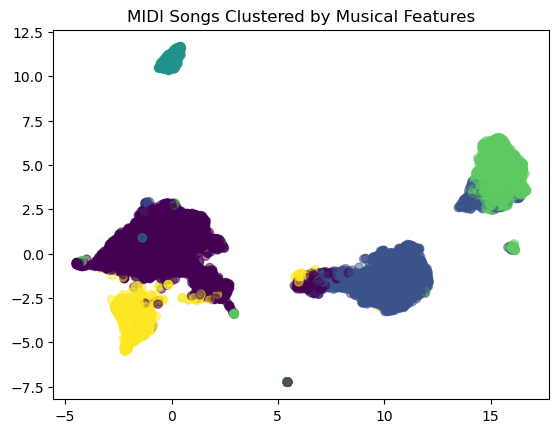

In [19]:
plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha = 0.5, c=clusters, cmap='viridis')
plt.title('MIDI Songs Clustered by Musical Features')
plt.show()

In [20]:
import pandas as pd

ClusteringDF = pd.DataFrame([{'Song name': k, 'Features': v} for k, v in DatasetFeatures.items()])
ClusteringDF['Cluster'] = clusters

In [22]:
from Preprocessing import *
path = os.path.realpath('Mono_CleanMidi')

GenrePreprocessing = {}

for cluster in np.unique(clusters):

   Dataset = {}
   
   for song in tqdm(ClusteringDF[ClusteringDF['Cluster'] == cluster]['Song name']):
      Func_Tempo = lambda t: 60_000_000 / t

      songPath = os.path.join(path, song)

      mid = mido.MidiFile(songPath)

      Dataset = ToGeneralInfo(mid, Dataset, song)


   #Remove garbage tracks
   for track in list(Dataset.keys()):
      if len(Dataset[track]['Tempo']) < 20:
         del Dataset[track]

   NormDataset = ReMap_Database(Dataset)
   Dataset = NormDataset

   GenrePreprocessing[cluster] = Dataset


 42%|████▏     | 2215/5268 [00:49<01:08, 44.81it/s]


UnboundLocalError: cannot access local variable 'Tempo' where it is not associated with a value

In [44]:
np.shape(GenrePreprocessing[0]['String']['Bars'])

(10557, 128, 16)